Welcome to the fourth and final week of our project of time-series prediction using ARIMA. Till now, we have understood the basics of time-series, we have perfomed EDA on our dataset, understood the stationarity of time-series and learnt about various tranformations that can be done on time-series data. This week, we are going to learn the main purpose of the project, about time-series prediction. Let's get started! 

## ARIMA model

I have directly picked this from the blog Machine learning mastery

An **ARIMA model** is a class of statistical model for analyzing and forecasting time series data. ARIMA is an acronym that stands for **AutoRegressive Integrated Moving Average**. It is a generalization of the simpler AutoRegressive Moving Average and adds the notion of integration.

This acronym is descriptive, capturing the key aspects of the model itself. Briefly, they are:

**1. AR:** Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.

**2. I:** Integrated. The use of differencing of raw observations (i.e. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.

**3. MA:** Moving Average. A model that uses the dependency between an observation and residual errors from a moving average model applied to lagged observations.

Each of these components are explicitly specified in the model as a parameter. A standard notation is used of ARIMA(p,d,q) where the parameters are substituted with integer values to quickly indicate the specific ARIMA model being used. The parameters of the ARIMA model are defined as follows:

1. p: The number of lag observations included in the model, also called the lag order.

2. d: The number of times that the raw observations are differenced, also called the degree of differencing.

3. q: The size of the moving average window, also called the order of moving average.

The method described above is decsribed as Box-Jenkins, devleoped by George Box and Gwilym Jenkins. The approach starts with the assumption that the process that generated the time series can be approximated using an **ARMA model** if it is stationary or an **ARIMA model** if it is non-stationary.

The next question that comes here is, how do we find out the values of p,d and q? It is usually based on the intuitions derived from the ACF and PACF plots. It is more of a hit and trial process wherein we guess the values to be kept in p and q. 

#### Identification of an AR model is often best done with the PACF.

For an AR model, the theoretical PACF “shuts off” past the order of the model. The phrase “shuts off” means that in theory the partial autocorrelations are equal to 0 beyond that point. Put another way, the number of non-zero partial autocorrelations gives the order of the AR model. By the “order of the model” we mean the most extreme lag of x that is used as a predictor.

#### Identification of an MA model is often best done with the ACF rather than the PACF.

For an MA model, the theoretical PACF does not shut off, but instead tapers toward 0 in some manner. A clearer pattern for an MA model is in the ACF. The ACF will have non-zero autocorrelations only at lags involved in the model.

I am going to show the above things in our air passenger dataset and it will be clearer. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from pandas import DataFrame
from pandas import concat
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.seasonal import seasonal_decompose
register_matplotlib_converters()
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller


from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from itertools import combinations
from statsmodels.tsa.arima_model import ARIMA as ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

plt.rcParams["figure.figsize"] = [16,9]

E:\Anaconda3\envs\tf-gpu\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
series = pd.read_csv(r"Air_passenger.csv", header=0, index_col=0,
parse_dates=True, squeeze=True)
series_diff = series.diff()
series_diff = series_diff.dropna()

log_series = np.log(series)

series_diff = series.diff()
series_diff = series_diff.dropna()

log_series_diff = log_series.diff()
log_series_diff = log_series_diff.dropna()

movingAverage = log_series.rolling(window=12).mean()
ma_log_series=log_series-movingAverage
ma_log_series = ma_log_series.dropna()

shift_log_series = log_series - log_series.shift()
shift_log_series = shift_log_series.dropna()


I am going to be using the data that we obtained by differencing the time-series once. The code below is to plot the ACF and PACF plots. We have already talked about the ACF and PACF plots in the week 2 assignment. Make sure you are clear with those assignments before jumping to this segment. 

Note that we will be using log_series_diff. Logging a time series straightens out the exponential growth patterns and reduces the variance.  Although it does not eliminate the upward trend in the data, it can deflate the trend so that it can  be better fitted by a ARIMA model. Differencing is an explicit option in ARIMA models.  To show the percentage change in the time series, the first difference of log is used.   Hence, the plot has been drawn on log_series_diff.  Notice the y-axis units on your plot, it will be % change in value.

In [3]:
def acfpacf(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

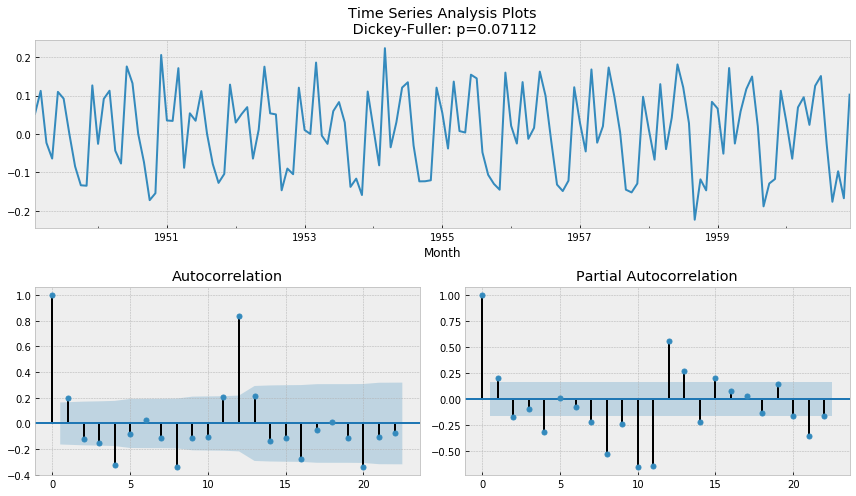

In [4]:
acfpacf(log_series_diff)

Now, for finidng the value of AR, the p, we will look at the PACF plot on thr right and try to look at the point where the PACF shuts off which means where we see drastic drop in the PACF plot and it happens after 1 so the value of p can be taken between 1-2. For convenience, we will take 1.

Now, the q value will be where we see exponential decrease in the ACF plot. We are not looking for a drastic change, we are rather looking for a curve that turns asymptotic. We can see that happening after 1. Now, we will look at where these changes, related to both p and q happen for the first time. 

If the above text doesn't make much sense, we will try another acf pacf plot which gives us more information about choosing p and q. The above one is good to determine the confidence intervals. The method discussed below will be used to determine the values of p and q at a glance. 

E:\Anaconda3\envs\tf-gpu\lib\site-packages\statsmodels\tsa\stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


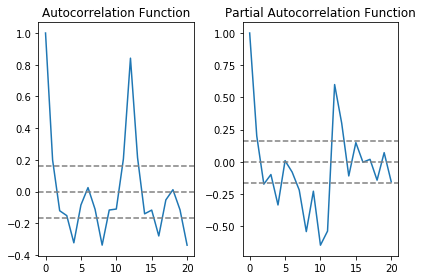

In [5]:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(log_series_diff, nlags=20)
lag_pacf = pacf(log_series_diff, nlags=20, method='ols')

plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(log_series_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(log_series_diff)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')            

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(log_series_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(log_series_diff)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
            
plt.tight_layout()

In the above graphs, we only have to see when the acf and pacf plot cuts the baseline for the first time. In the case od p, to be taken from the pacf plot, the value is somewhere between 1-2 and the same for q. Let us try the value of 1 first: 

E:\Anaconda3\envs\tf-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
E:\Anaconda3\envs\tf-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Plotting ARIMA model
                             ARIMA Model Results                              
Dep. Variable:          D.#Passengers   No. Observations:                  143
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 124.804
Method:                       css-mle   S.D. of innovations              0.101
Date:                Thu, 20 Aug 2020   AIC                           -241.608
Time:                        20:24:42   BIC                           -229.756
Sample:                    02-01-1949   HQIC                          -236.792
                         - 12-01-1960                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0098      0.010      0.993      0.322      -0.010       0.029
ar.L1.D.#Passengers    -0.5826      0.128     -4.536      0.000      -0.834      -0

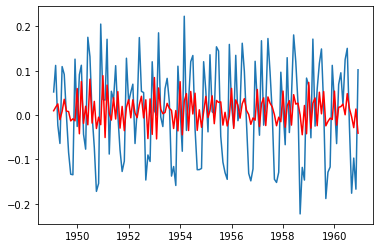

In [6]:
model = ARIMA(log_series, order=(1,1,1))
results_ARIMA = model.fit(disp=-1)
plt.plot(log_series_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
print('Plotting ARIMA model')
print(results_ARIMA.summary())

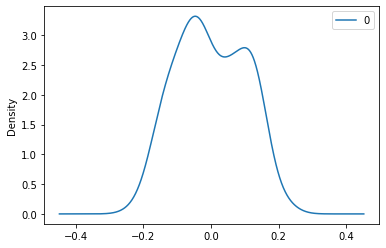

In [7]:
residuals = DataFrame(results_ARIMA.resid)
residuals.plot(kind='kde')
plt.show()

In [8]:
print(residuals.describe())

                0
count  143.000000
mean    -0.000026
std      0.101389
min     -0.223351
25%     -0.078643
50%     -0.009057
75%      0.089547
max      0.227127


Let us 2,2 as the p,q values and see the results

E:\Anaconda3\envs\tf-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
E:\Anaconda3\envs\tf-gpu\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
E:\Anaconda3\envs\tf-gpu\lib\site-packages\statsmodels\tsa\tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
E:\Anaconda3\envs\tf-gpu\lib\site-packages\statsmodels\tsa\tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
E:\Anaconda3\envs\tf-gpu\lib\site-packages\statsmodels\tsa\tsatools.py:669: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
E:\Anaconda3\envs\tf-gpu\lib\site-packages\stats

Plotting ARIMA model
                             ARIMA Model Results                              
Dep. Variable:          D.#Passengers   No. Observations:                  143
Model:                 ARIMA(2, 1, 2)   Log Likelihood                 149.640
Method:                       css-mle   S.D. of innovations              0.084
Date:                Thu, 20 Aug 2020   AIC                           -287.281
Time:                        20:24:42   BIC                           -269.504
Sample:                    02-01-1949   HQIC                          -280.057
                         - 12-01-1960                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0096      0.003      3.697      0.000       0.005       0.015
ar.L1.D.#Passengers     1.6293      0.039     41.868      0.000       1.553       1

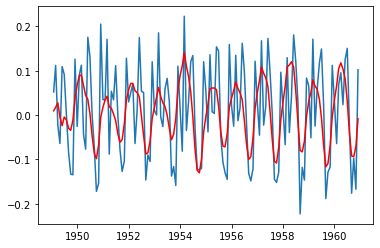

In [9]:
model = ARIMA(log_series, order=(2,1,2))
results_ARIMA = model.fit(disp=-1)
plt.plot(log_series_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
print('Plotting ARIMA model')
print(results_ARIMA.summary())

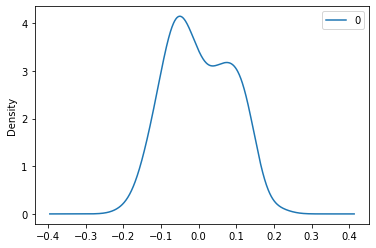

In [10]:
residuals = DataFrame(results_ARIMA.resid)
residuals.plot(kind='kde')
plt.show()

In [11]:
print(residuals.describe())

                0
count  143.000000
mean     0.001691
std      0.085116
min     -0.193387
25%     -0.063327
50%     -0.005020
75%      0.074606
max      0.210672


We can see from the fit of the model and residual details that model with p and q both as 2, performs better. 

## Forecast using ARIMA model 

The ARIMA model can be used to forecast future time steps. We can use the predict() function on the ARIMAResults object4 to make predictions. It accepts the index of the time steps to make predictions as arguments. These indexes are relative to the start of the training dataset used to make predictions.

Now there are two methods in which the predictions can be made, one is to use test and train and compare the predictions with the test data. The second is to use the sntire data and compare the predictions with the original data. You can use either of these. I am going to show the elaborate method of using the netire data and how can we predict on the original dataset after reverting all the transformations we have made till now. This makes it easier to compare and visualize. 

In [12]:
pred = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(pred.head())

Month
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023890
dtype: float64


Using the codes above, we have the predicted values. Now it is time to revert the transformations we had made to make our series stationary. 

First, we find cumulative sums of all the elements in our series as we have differneced our time series.

In [13]:
pred_sum = pred.cumsum()
print(pred_sum)

Month
1949-02-01    0.009580
1949-03-01    0.027071
1949-04-01    0.054742
1949-05-01    0.050221
1949-06-01    0.026331
                ...   
1960-08-01    1.372553
1960-09-01    1.280203
1960-10-01    1.186190
1960-11-01    1.116266
1960-12-01    1.108139
Length: 143, dtype: float64


What we have seen above is the differences, or the delta, but we need the absolute values too. So, we will start all these delta to the first value on the time series to get the log series. 

In [14]:
pred_log = pd.Series(log_series.iloc[0], index=log_series.index)
pred_log = pred_log.add(pred_sum, fill_value=0)
pred_log.head()

Month
1949-01-01    4.718499
1949-02-01    4.728079
1949-03-01    4.745570
1949-04-01    4.773241
1949-05-01    4.768720
dtype: float64

We have the log of our time series, now it is time to find exponential values to remove the log. 

if x=log(y), 

in order to find y, 

y=e^x. We will be doing the same: 

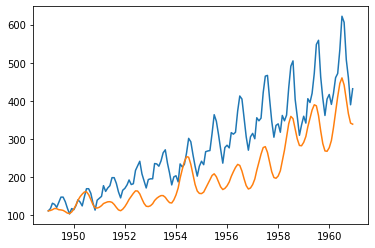

In [15]:
final_pred = np.exp(pred_log)
plt.plot(series)
plt.plot(final_pred)

Though not perfect, our model is working just fine. We can also try SARIMA models and LSTM models and see if they perform better. 

With this, we come to an end to our time-series forecasting project. The assignment for this week to make predictions on the mean temperature dataset. Although we came to know in week 3 that our data is stationary, please fit series_diff, rest things remain same as in the assignment. 

series_diff = series.diff(12)
series_diff = series_diff.dropna()

You will find that the predictions are not perfect, it is because we didn't use other factors in predicting mean temperature like humidity, wind, pressure, etc. Multivariate time-series can be done later accordingly. Use of LSTM can also be done. 

See you all in the next project! 